# Project 02 - Image Processing

## Student Information

- Full name: Nguyễn Bình Minh
- Student ID: 22127266
- Class: 22CLC03

## Required Libraries

In [1]:
# IMPORT YOUR LIBS HERE
import matplotlib.pyplot as plt
import PIL
import numpy as np

## Function Definitions

In [2]:
def read_img(img_path):
    '''
    Read image from img_path

    Parameters
    ----------
    img_path : str
        Path of image

    Returns
    -------
        Image
    '''

    # YOUR CODE HERE
    img = PIL.Image.open(img_path)
    return np.asarray(img)


def show_img(img):
    '''
    Show image

    Parameters
    ----------
    img : np.ndarray
        Image
    '''

    # YOUR CODE HERE
    plt.imshow(img)
    plt.show()


def save_img(img, img_path):
    '''
    Save image to img_path

    Parameters
    ----------
    img : np.ndarray
        Image
    img_path : str
        Path of image
    '''

    # YOUR CODE HERE
    PIL_img = PIL.Image.fromarray(img.astype(np.uint8))
    PIL_img.save(img_path)

#--------------------------------------------------------------------------------
# YOUR FUNCTIONS HERE
def change_brightness(img, level):
    '''
    Change the brightness of the image

    Parameters
    ----------
    img : np.ndarray
        Image array
    level : int
        Brightness level to be added. From [-255, 0) to decease brightness level, from (0, -255] to increase brightness level.

    Returns
    -------
    np.ndarray
        Brightness adjusted image
    '''

    # Change to float => avoid overflow
    new_img = img.astype(float) + level

    # Change back to int => normal rbg value
    new_img = np.clip(new_img, 0, 255).astype(int)

    return new_img

def change_contrast(img, level):
    '''
    Change the contrast of the image

    Parameters
    ----------
    img : np.ndarray
        Image array
    level : float
        Contrast adjustment factor.
        Values > 1 increase contrast, values between 0 and 1 decrease contrast.

    Returns
    -------
    np.ndarray
        Contrast adjusted image
    '''

    # Convert image to float to prevent overflow/underflow
    img = img.astype(float)

    # Calculate the mean of the image
    mean = np.mean(img)

    # Apply contrast adjustment
    new_img = mean + level * (img - mean)

    # Clip values to be in the range [0, 255]
    new_img = np.clip(new_img, 0, 255).astype(int)

    return new_img

def flip_image(img, axis):
    '''
    Flip the image along the specified axis

    Parameters
    ----------
    img : np.ndarray
        Image array
    axis : str
        Axis along which to flip the image ('Vertical' or 'Horizontal')

    Returns
    -------
    np.ndarray
        Flipped image
    '''

    if axis == 'Horizontal':
        new_img = img[::-1]
    if axis == 'Vertical':
        new_img = img[:, ::-1]
    return new_img

def green_blue_yellow_scaling_image(img):
    gby_img = 0.2989 * img[:, :, 0] + 0.5870 * img[:, :, 1] + 0.1140 * img[:, :, 2]
    gby_img = gby_img.astype(np.uint8)
    return gby_img

def grayscaling_image(img):
    '''
    Convert an RGB image to grayscale image

    Parameters
    ----------
    img : np.ndarray
        RGB image array

    Returns
    -------
    np.ndarray
        Grayscale image
    '''

    # Calculate the gray value
    gray_pixels = np.dot(img[..., 0:3].astype(float), [0.2989, 0.5870, 0.1140])

    # Put the gray value across the rgb
    gray_img = np.stack((gray_pixels, gray_pixels, gray_pixels), axis=-1)

    # Over/Underflow  check
    gray_img = np.clip(gray_img, 0, 255)

    return gray_img.astype(int)

def add_sepia_filter(img):
    '''
    Convert an RGB image to sepia

    Parameters
    ----------
    img : np.ndarray
        RGB image array

    Returns
    -------
    np.ndarray
        Image with sepia filter
    '''

    sepia_filter = np.array([[0.393, 0.769, 0.189],
                            [0.349, 0.686, 0.168],
                            [0.272, 0.534, 0.131]])

    sepia_red_pixels = np.dot(img[..., 0:3], sepia_filter[0])
    sepia_green_pixels = np.dot(img[..., 0:3], sepia_filter[1])
    sepia_blue_pixels = np.dot(img[..., 0:3], sepia_filter[2])

    sepia_img = np.stack((sepia_red_pixels, sepia_green_pixels, sepia_blue_pixels), axis=-1)

    sepia_img = np.clip(sepia_img, 0, 255)

    return sepia_img.astype(int)

def conv2d_fast(img, krn):
    '''
    Performs a 2D convolution on an image using a given kernel, optimized for speed.

    Parameters:
    ----------
    img (numpy.ndarray): The input image.
    krn (numpy.ndarray): The convolution kernel.

    Returns:
    ----------
    numpy.ndarray: The result of the convolution.
    '''

    is0, is1, ks0, ks1 = *img.shape, *krn.shape
    rs0, rs1 = is0 - ks0 + 1, is1 - ks1 + 1

    ix0 = np.arange(ks0)[:, None] + np.arange(rs0)[None, :]
    ix1 = np.arange(ks1)[:, None] + np.arange(rs1)[None, :]

    res = krn[:, None, :, None] * img[(ix0.ravel()[:, None], ix1.ravel()[None, :])].reshape(ks0, rs0, ks1, rs1)
    res = res.transpose(1, 3, 0, 2).reshape(rs0, rs1, -1).sum(axis = -1)

    return res

def conv2d_faster(img, krn):
    is0, is1 = img.shape
    ks0, ks1 = krn.shape

    # Compute the shape of the output
    rs0, rs1 = is0 - ks0 + 1, is1 - ks1 + 1

    # Define the strides for the input image
    strides = img.strides + img.strides
    img_2d = np.lib.stride_tricks.as_strided(img, shape=(rs0, rs1, ks0, ks1), strides=strides)

    # Perform the convolution
    result = np.tensordot(img_2d, krn, axes=((2, 3), (0, 1)))

    return result

def convolution(img, krn):
    '''
    Performs a 2D convolution on a 3-channel (RGB) image using a given kernel, optimized for speed.

    Parameters:
    ----------
    img (numpy.ndarray): The input 3-channel image.
    krn (numpy.ndarray): The convolution kernel.

    Returns:
    ----------
    numpy.ndarray: The result of the convolution.
    '''

    img = np.pad(img, pad_width=((1, 1), (1, 1), (0, 0)), mode='constant', constant_values=0)

    img_r = img[:, :, 0]
    img_b = img[:, :, 1]
    img_g = img[:, :, 2]

    new_img_r = conv2d_fast(img_r, krn)
    new_img_b = conv2d_fast(img_b, krn)
    new_img_g = conv2d_fast(img_g, krn)

    new_img = np.stack((new_img_r, new_img_b, new_img_g), axis=-1)

    new_img = np.clip(new_img, 0, 255)

    return new_img.astype(int)

def convolution_v8(img, krn):
    img_r = img[:, :, 0]
    img_b = img[:, :, 1]
    img_g = img[:, :, 2]

    new_img_r = conv2d_faster(img_r, krn)
    new_img_b = conv2d_faster(img_b, krn)
    new_img_g = conv2d_faster(img_g, krn)

    new_img = np.stack((new_img_r, new_img_b, new_img_g), axis=-1)

    return new_img.astype(int)

def crop_circle(img):
    '''
    Crops an image to keep the content within a circle centered in the image.

    Parameters:
    ----------
    img (numpy.ndarray): The input image to be cropped.

    Returns:
    ----------
    numpy.ndarray: The cropped image.
    '''

    h, w = img.shape[0], img.shape[1]
    r = h//2

    center_x, center_y = h//2, w//2

    Y, X = np.ogrid[:h, :w]

    # Contrast the coordinate within the circle(0 and 1)
    mask = (X - center_x)**2 + (Y - center_y)**2 <= r**2

    new_img = img * mask[:, :, np.newaxis]

    return new_img

def crop_center_square(img, crop_size):
    '''
        

    Parameters
    ----------
    image_array : np.ndarray
        3D numpy array representing the image (height, width, channels).
    crop_size : int
        The size of the square crop, calculate from the center of the image (pixel).

    Returns
    -------
    np.ndarray
        Cropped square image as a 3D numpy array.
    '''
    height, width, channels = img.shape
    
    # Ensure the crop size is not larger than the image dimensions
    crop_size = min(crop_size, height, width)
    
    # Calculate the center of the image
    center_y, center_x = height // 2, width // 2
    
    # Calculate the coordinates for cropping
    half_crop = crop_size // 2
    y1 = max(center_y - half_crop, 0)
    y2 = min(center_y + half_crop, height)
    x1 = max(center_x - half_crop, 0)
    x2 = min(center_x + half_crop, width)
    
    # Crop the image
    cropped_image = img[y1:y2, x1:x2]
    
    # Handle the case where the cropped area is smaller than the desired crop_size
    if cropped_image.shape[0] < crop_size or cropped_image.shape[1] < crop_size:
        padded_image = np.pad(cropped_image, ((0, crop_size - cropped_image.shape[0]), (0, crop_size - cropped_image.shape[1]), (0, 0)), mode='constant')
        return padded_image
    
    return cropped_image

# https://www.youtube.com/watch?v=v9CFu4r6tPY
def zoom_img(img, scale):
    '''
    Zooms into an image by a given scale factor.

    Parameters:
    ----------
    img (numpy.ndarray): The input image to be zoomed.
    scale (float): The zoom factor. A scale > 1 will zoom in, a scale < 1 will zoom out.

    Returns:
    ----------
    numpy.ndarray: The zoomed image.
    '''

    new_rows = int(scale*img.shape[0])
    new_cols = int(scale*img.shape[1])

    zoomed_img = np.zeros((new_rows, new_cols, img.shape[2]), dtype=int)

    row_indices = np.clip((np.arange(new_rows) / scale).astype(int), 0, img.shape[0] - 1)
    col_indices = np.clip((np.arange(new_cols) / scale).astype(int), 0, img.shape[1] - 1)

    row_indices = row_indices[:, np.newaxis]

    # Use advanced indexing to construct the zoomed image
    zoomed_img = img[row_indices, col_indices, :]
    zoomed_img = np.clip(zoomed_img, 0 , 255)

    return zoomed_img

def crop_rotated_ellipse(img):
    '''
    Crops an image to keep the content within two rotated ellipses centered in the image.

    Parameters:
    ----------
    img (numpy.ndarray): The input image to be cropped.

    Returns:
    ----------
    numpy.ndarray: The cropped image.
    '''

    h, w = img.shape[0], img.shape[1]

    # Step 1: Calculate k (distance from center to corner)
    k = np.sqrt((w/2)**2 + (h/2)**2)

    # Step 2: Choose a reasonable value for a such that a != b
    a = w / 3

    # Step 3: Calculate b using a^2 + b^2 = k^2
    b = np.sqrt(k**2 - a**2)

    # Step 4: Define the mask for the rotated ellipse
    Y, X = np.ogrid[:h, :w]
    center_x, center_y = w // 2, h // 2

    # Rotation transformation
    cos45 = 1 / np.sqrt(2)
    sin45 = 1 / np.sqrt(2)
    
    X_rot = cos45 * (X - center_x) + sin45 * (Y - center_y)
    Y_rot = -sin45 * (X - center_x) + cos45 * (Y - center_y)

    mask1 = ((X_rot)**2 / a**2) + ((Y_rot)**2 / b**2) <= 1

    mask2 = ((Y_rot)**2 / a**2) + ((X_rot)**2 / b**2) <= 1

    mask = mask1 | mask2

    new_img = img * mask[:, :, np.newaxis]

    return new_img

def array_to_image(img):
    '''
    Turn a numpy.ndarray object into PIL.Image object

    Parameters:
    ----------
    img (numpy.ndarray): The input image(array)

    Returns:
    ----------
    PIL.Image: The PIL.Image object.
    '''
    return PIL.Image.fromarray(img)

def add_suffix(image_path, suffix):
    '''
    Add suffix to the image name

    Parameters:
    ----------
    image_path (string): The input image path
    suffix (string): The suffix(name of the image processing function)

    Returns:
    ----------
    new_filename (string): The new file name
    '''

    dot_index = image_path.rfind('.')
    base = image_path[:dot_index]
    ext = image_path[dot_index:]
    new_filename = f"{base}_{suffix}{ext}"
    return new_filename

def processing_image(img_path, img, choice):
    '''
    Processing the input image based on the choice

    Parameters:
    ----------
    image_path (string): The input image path
    img (np.ndarray): The image
    choice(string): The processing method chosen

    Returns:
    ----------
    The result image showed by plt and the saved image with the method applied.
    '''

    blur_kernel = np.ones((3,3))/9
    sharpen_kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])

    if choice == '1':
        # level = int(input("Enter brightness level: "))
        result_img = change_brightness(img, level=-200)
        show_img(result_img)
        save_img(result_img, add_suffix(img_path, "brightness"))
    elif choice == '2':
        # level = float(input("Enter contrast level: "))
        result_img = change_contrast(img, level=4)
        show_img(result_img)
        save_img(result_img, add_suffix(img_path, "contrast"))
    elif choice == '3':
        # axis = input("Enter axis to flip (Horizontal/Vertical): ")
        result_img = flip_image(img, axis='Vertical')
        show_img(result_img)
        save_img(result_img, add_suffix(img_path, "vertical"))

        result_img = img

        result_img = flip_image(img, axis='Horizontal')
        show_img(result_img)
        save_img(result_img, add_suffix(img_path, "horizontal"))
    elif choice == '4':
        result_img = grayscaling_image(img)
        show_img(result_img)
        save_img(result_img, add_suffix(img_path, "gray"))

        result_img = img

        result_img = add_sepia_filter(img)
        show_img(result_img)
        save_img(result_img, add_suffix(img_path, "sepia"))
    elif choice == '5':
        result_img = convolution(img, blur_kernel)
        show_img(result_img)
        save_img(result_img, add_suffix(img_path, "blur"))
        print(result_img.shape)

        result_img = img

        result_img = convolution(img, sharpen_kernel)
        show_img(result_img)
        save_img(result_img, add_suffix(img_path, "sharpen"))
        print(result_img.shape)
    elif choice == '6':
        result_img = crop_center_square(img, 100)
        show_img(result_img)
        save_img(result_img, add_suffix(img_path, "center_crop"))
    elif choice == '7':
        result_img = crop_circle(img)
        show_img(result_img)
        save_img(result_img, add_suffix(img_path, "circle_crop"))

        result_img = img

        result_img = crop_rotated_ellipse(img)
        show_img(result_img)
        save_img(result_img, add_suffix(img_path, "ellipse_crop"))
    elif choice == '8':
        result_img = zoom_img(img, scale=2)
        show_img(result_img)
        save_img(result_img, add_suffix(img_path, "zoom_out"))

<ins>Note:</ins> For clarity, include docstrings with each function.

## Your tests

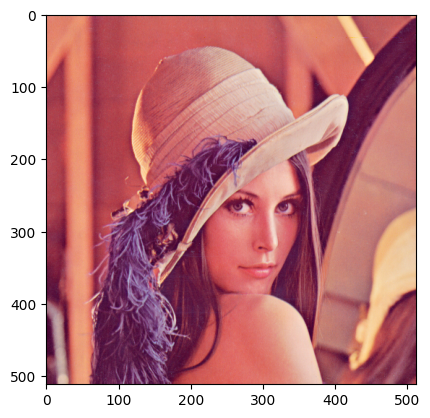

(512, 512, 3)


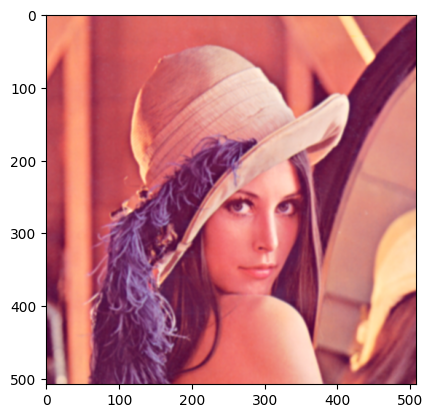

(508, 508, 3)


In [10]:
# YOUR CODE HERE
#   https://techmaster.vn/posts/35474/convolution-tich-chap-giai-thich-bang-code-thuc-te
# https://www.youtube.com/watch?v=8rrHTtUzyZA
test_img_path = "Picture/Test/test10.png"

img = read_img(test_img_path)
show_img(img)
print(img.shape)

# img = np.array([[1, 2, 3, 4],
#                   [5, 6, 7, 8],
#                   [9, 10, 11, 12],
#                   [13, 14, 15, 16]])
# img.shape
# kernel = np.array([[1, 0],
#                      [0, -1]])


def conv2d_fast_test(img, krn):
    '''
    Performs a 2D convolution on an image using a given kernel, optimized for speed.

    Parameters:
    ----------
    img (numpy.ndarray): The input image.
    krn (numpy.ndarray): The convolution kernel.

    Returns:
    ----------
    numpy.ndarray: The result of the convolution.
    '''

    is0, is1, ks0, ks1 = *img.shape, *krn.shape
    rs0, rs1 = is0 - ks0 + 1, is1 - ks1 + 1
    # print(rs0, rs1)

    ix0 = np.arange(ks0)[:, None] + np.arange(rs0)[None, :]
    # print(ix0)
    ix1 = np.arange(ks1)[:, None] + np.arange(rs1)[None, :]
    # print(ix0)

    res = krn[:, None, :, None] * img[(ix0.ravel()[:, None], ix1.ravel()[None, :])].reshape(ks0, rs0, ks1, rs1)
    # print(res)
    # print(krn[:, None, :, None])
    # print(ix0.ravel()[:, None])
    # print(ix1.ravel()[None, :])
    # print(img[(ix0.ravel()[:, None], ix1.ravel()[None, :])])
    # print(ks0, rs0, ks1, rs1)
    # print(img[(ix0.ravel()[:, None], ix1.ravel()[None, :])].reshape(ks0, rs0, ks1, rs1))

    res = res.transpose(1, 3, 0, 2).reshape(rs0, rs1, -1).sum(axis = -1)
    # print(res.transpose(1, 3, 0, 2))
    # print(res.transpose(1, 3, 0, 2).reshape(rs0, rs1, -1))
    print(res)

    return res

def conv2d(img, krn):
    is0, is1, ks0, ks1 = *img.shape, *krn.shape
    rs0, rs1 = is0 - ks0 + 1, is1 - ks1 + 1
    res = np.zeros((rs0, rs1), dtype = float)

    for i in range(rs0):
        for j in range(rs1):
            res[i, j] = (krn * img[i : i + ks0, j : j + ks1]).sum()

    # print(res)
    return res

def convolution_v7(img, krn):
    '''
    Performs a 2D convolution on a 3-channel (RGB) image using a given kernel.

    Parameters:
    ----------
    img (numpy.ndarray): The input 3-channel image.
    krn (numpy.ndarray): The convolution kernel.

    Returns:
    ----------
    numpy.ndarray: The result of the convolution.
    '''

    img = np.pad(img, pad_width=((1, 1), (1, 1), (0, 0)), mode='constant', constant_values=0)

    img_r = img[:, :, 0]
    img_b = img[:, :, 1]
    img_g = img[:, :, 2]

    new_img_r = conv2d(img_r, krn)
    new_img_b = conv2d(img_b, krn)
    new_img_g = conv2d(img_g, krn)

    new_img = np.stack((new_img_r, new_img_b, new_img_g), axis=-1)

    new_img = np.clip(new_img, 0, 255)

    return new_img.astype(int)

def convolution_v9(img, krn):
    '''
    Performs a 2D convolution on a 3-channel (RGB) image using a given kernel, optimized for speed.

    Parameters:
    ----------
    img (numpy.ndarray): The input 3-channel image.
    krn (numpy.ndarray): The convolution kernel.

    Returns:
    ----------
    numpy.ndarray: The result of the convolution.
    '''

    img = np.pad(img, pad_width=((1, 1), (1, 1), (0, 0)), mode='constant', constant_values=0)

    img_r = img[:, :, 0]
    img_b = img[:, :, 1]
    img_g = img[:, :, 2]

    new_img_r = conv2d_fast_test(img_r, krn)
    new_img_b = conv2d_fast_test(img_b, krn)
    new_img_g = conv2d_fast_test(img_g, krn)

    new_img = np.stack((new_img_r, new_img_b, new_img_g), axis=-1)

    new_img = np.clip(new_img, 0, 255)

    return new_img.astype(int)

def conv2d_medium(img, krn):
    import numpy as np

    is0, is1, num , ks0, ks1 = *img.shape, *krn.shape
    rs0, rs1 = is0 - ks0 + 1, is1 - ks1 + 1
    res = np.zeros((rs0, rs1, num), dtype = float)
    
    for k in range(ks0):
        for l in range(ks1):
            res[:,:,:] += krn[k, l] * img[k : k + rs0, l : l + rs1,:]

    res = np.clip(res, 0, 255)

    return res.astype(np.uint8)

# new_img = conv2d_fast_test(img, kernel)
# print(new_img)

blur_kernel = np.ones((3,3))/9
sharpen_kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])

gaussian_blur_kernel = np.array([[1, 4, 6, 4, 1],
                                 [4, 16, 24, 26, 4],
                                 [6, 24, 36, 24, 6],
                                 [4, 16, 24, 26, 4],
                                 [1, 4, 6, 4, 1]])/256


# new_img = convolution_v7(img, gaussian_blur_kernel)
new_img = conv2d_medium(img, gaussian_blur_kernel)

show_img(new_img)
print(new_img.shape)

# for choice in range(9):
#     processing_image(test_img_path, img, str(choice))

## Main FUNCTION

In [ ]:
# YOUR CODE HERE
def main():
    print("Image Processing Menu")
    print("1. Change Brightness")
    print("2. Change Contrast")
    print("3. Flip Image")
    print("4. Grayscale Image/Sepia Filter")
    print("5. Blur/Sharpen Image")
    print("6. Crop Center")
    print("7. Crop Circle/Ellipse")
    print("8. Zoom In/Out")
    print("0. All")

    img_path = input("Enter image path: ")

    # img_path = "Picture/Test/test10.png"
    img = read_img(img_path)

    choice = input("Enter your choice (0-8): ")

    if choice == '0':
        for c in range(9):
            print(c)
            processing_image(img_path, img, str(c))
    else:
        processing_image(img_path, img, choice)


Image Processing Menu
1. Change Brightness
2. Change Contrast
3. Flip Image
4. Grayscale Image/Sepia Filter
5. Blur/Sharpen Image
6. Crop Center
7. Crop Circle/Ellipse
8. Zoom In/Out
0. All


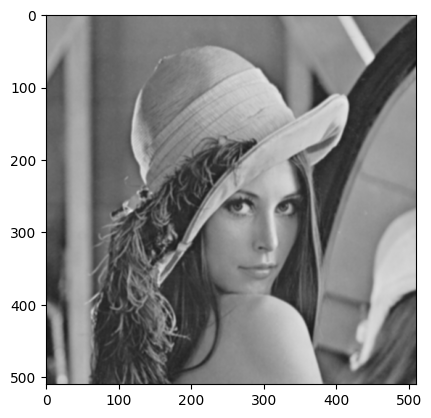

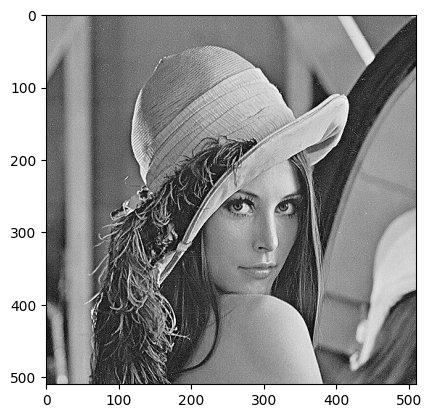

In [ ]:
# Call main function
if __name__=="__main__":
    main()